'all_trained_models_kucuk_2class.pkl' dosyasından eğitilmiş modeller yükleniyor...
Test görüntüsü için öznitelikler çıkarılıyor...
Öznitelikler ölçeklendiriliyor ve PCA dönüşümü uygulanıyor...
-> SVM Tahmini: drone (Güven: 99.45%)
-> MLP Tahmini: drone (Güven: 99.92%)
-> XGBoost Tahmini: drone (Güven: 99.02%)


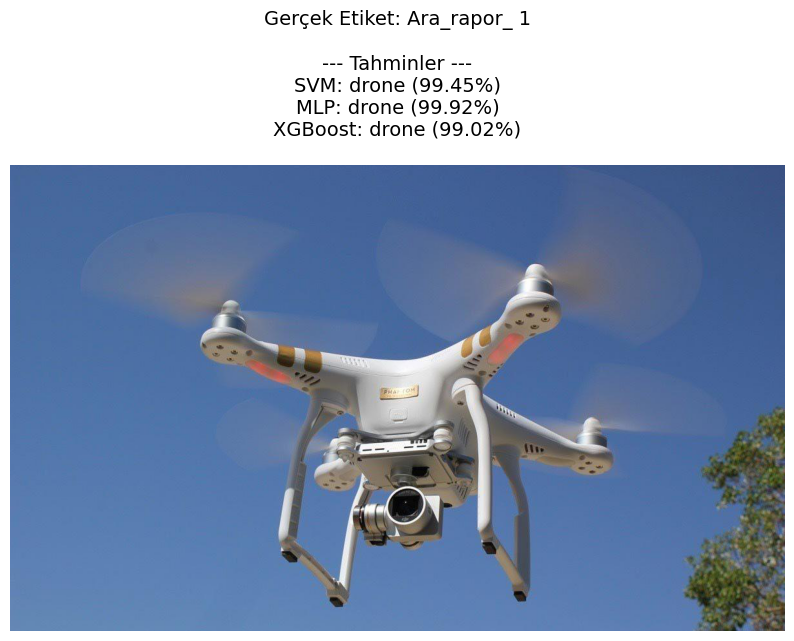

In [3]:
# Gerekli kütüphaneleri projemize dahil ediyoruz
import joblib
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)


MODELS_FILE = 'all_trained_models_kucuk_2class.pkl'
SINGLE_IMAGE_PATH = "C:/Users/mkasl/Desktop/donem5/yap470/Ara_rapor_ 1/1.jpg" 

IMAGE_SIZE = (128, 128)
BINS = 8
PIXELS_PER_CELL = (8, 8)
CELLS_PER_BLOCK = (2, 2)
ORIENTATIONS = 9

def extract_color_histogram(image, bins=(BINS, BINS, BINS)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()



if not os.path.exists(MODELS_FILE):
    print(f"HATA: Gerekli model dosyası bulunamadı -> '{MODELS_FILE}'")
    exit()

print(f"'{MODELS_FILE}' dosyasından eğitilmiş modeller yükleniyor...")
saved_data = joblib.load(MODELS_FILE)
trained_models = saved_data['models']
scaler = saved_data['scaler']
pca = saved_data['pca']
le = saved_data['le']


if not os.path.exists(SINGLE_IMAGE_PATH):
    print(f"HATA: Test görüntüsü bulunamadı -> '{SINGLE_IMAGE_PATH}'")
    exit()

image = cv2.imread(SINGLE_IMAGE_PATH)
image_for_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
image_resized = cv2.resize(image, IMAGE_SIZE)
gray_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

print("Test görüntüsü için öznitelikler çıkarılıyor...")

hog_features = hog(gray_image, orientations=ORIENTATIONS,
                   pixels_per_cell=PIXELS_PER_CELL,
                   cells_per_block=CELLS_PER_BLOCK,
                   block_norm='L2-Hys')

color_features = extract_color_histogram(image_resized)
combined_features = np.concatenate([hog_features, color_features])

print("Öznitelikler ölçeklendiriliyor ve PCA dönüşümü uygulanıyor...")

features_to_process = combined_features.reshape(1, -1)
features_scaled = scaler.transform(features_to_process)
features_pca = pca.transform(features_scaled)

predictions = {}

true_label = os.path.basename(os.path.dirname(SINGLE_IMAGE_PATH))

for model_name, model in trained_models.items():
    pred_index = model.predict(features_pca)[0]
    pred_label = le.inverse_transform([pred_index])[0]
    
    pred_probas = model.predict_proba(features_pca)[0]
    pred_confidence = pred_probas[pred_index]
    
    predictions[model_name] = {
        'tahmin': pred_label,
        'güven': f"{pred_confidence:.2%}"
    }
    print(f"-> {model_name} Tahmini: {pred_label} (Güven: {pred_confidence:.2%})")

plt.figure(figsize=(10, 12))
plt.imshow(image_for_display)

title_text = f"Gerçek Etiket: {true_label}\n\n--- Tahminler ---\n"
for model_name, result in predictions.items():
    title_text += f"{model_name}: {result['tahmin']} ({result['güven']})\n"

plt.title(title_text, fontsize=14)
plt.axis('off')
plt.show()